# Ucitavanje podataka

In [2]:
import joblib
import numpy as np
# ucitavanje prethodno podeljenih skupova podataka

#ucitavanje skupova podataka bez redukcije dimenzionalnosti
X_org_train, X_org_val, y_org_train, y_org_validation = joblib.load("unsw_trv_unprocessed.pkl")
X_org_test, y_org_test = joblib.load("unsw_test_unprocessed.pkl")
X_org_combined = np.concatenate([X_org_train, X_org_val], axis=0)
y_org_combined = np.concatenate([y_org_train, y_org_validation], axis=0)
print("Original Training set:" + str(X_org_combined.shape) + "\nOriginal Test set:" + str(X_org_test.shape))


# ucitavanje korelaciono obradjenih skupova podataka
X_test, y_test = joblib.load("unsw_corr_test.pkl")
X_train, y_train = joblib.load("unsw_corr_train.pkl")
X_validation, y_validation = joblib.load("unsw_corr_val.pkl")
X_combined = np.concatenate([X_train, X_validation], axis=0)
y_combined = np.concatenate([y_train, y_validation], axis=0)
print("Training set:" + str(X_combined.shape) + "\nTest set:" + str(X_test.shape))

#ucitavanje PCA transformisanih skupova podataka
_,_,y_train_pca,y_validation_pca = joblib.load("unsw_trv_unprocessed.pkl")
X_train_pca, X_validation_pca, X_test_pca = joblib.load("unsw_pca.pkl")
X_pca_combined = np.concatenate([X_train_pca, X_validation_pca], axis=0)
y_pca_combined = np.concatenate([y_train_pca, y_validation_pca], axis=0)
print("PCA Training set:" + str(X_pca_combined.shape) + "\nPCA Test set:" + str(X_test_pca.shape))

# ucitavanje autoenkoderski transformisanih skupova podataka
X_train_autoenc, y_train_autoenc = joblib.load("new_unsw_train_reduced_autoenc.pkl")
X_test_autoenc, y_test_eutoenc = joblib.load("new_unsw_test_reduced_autoenc.pkl")
print("Autoencoder Training set:" + str(X_train_autoenc.shape) + "\nAutoencoder Test set:" + str(X_test_autoenc.shape))

Original Training set:(175318, 41)
Original Test set:(82328, 41)
Training set:(198019, 18)
Test set:(82328, 18)
PCA Training set:(175318, 16)
PCA Test set:(82328, 16)
Autoencoder Training set:(175318, 20)
Autoencoder Test set:(82328, 20)


In [ ]:
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt

def train_mlp_classifier(X_train, X_test, y_train, y_test,
                    hidden_dims = [256, 128, 64],
                    dropout_rate = 0.1,
                    learning_rate = 0.0005,
                    epochs = 80,
                    batch_size=256):

    
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)    
    num_classes = len(le.classes_)
    input_dim = X_train.shape[1]
    
    print(f"Input features: {input_dim}")
    print(f"Number of classes: {num_classes}")
    print(f"Hidden layers: {hidden_dims}")
    
    model = Sequential()
    
    #input
    model.add(Dense(hidden_dims[0], activation='relu', input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    #hidden layers
    for hidden_dim in hidden_dims[1:]:
        model.add(Dense(hidden_dim, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(BatchNormalization())
    
    #output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(f"\nTotal parameters: {model.count_params():,}")
    
    
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
    
    print("\nPocinje treniranje...")
    start_time = time.time()
    
    history = model.fit(
        X_train, y_train_enc,
        validation_split=0.1,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    training_time = time.time() - start_time
    print(f"\nTreniranje zavrseno za {training_time:.2f} sekundi")
    
    y_pred_enc = np.argmax(model.predict(X_test, verbose=0), axis=1)
    y_pred = le.inverse_transform(y_pred_enc)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    print(f"\n{'='*70}")
    print("TEST SET REZULTATI")
    print(f"{'='*70}")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"F1-Macro: {f1_macro:.4f}")
    print(f"F1-Weighted: {f1_weighted:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    
    # vizuelizacija loss i accuracy tokom treniranja
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training & Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training & Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle(f'MLP Training ', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return {
        'model': model,
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'train_time': training_time,
        'history': history,
        'predictions': y_pred
    }

In [4]:
results ={}

Input features: 41
Number of classes: 10
Hidden layers: [256, 128, 64]


c:\Users\user\Faks\neuronske_mreze\projekat\venv\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Total parameters: 54,346

Pocinje treniranje...
Epoch 1/80
617/617 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.7541 - loss: 0.6899 - val_accuracy: 0.7930 - val_loss: 0.5451 - learning_rate: 5.0000e-04
Epoch 2/80
617/617 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7882 - loss: 0.5469 - val_accuracy: 0.7948 - val_loss: 0.5223 - learning_rate: 5.0000e-04
Epoch 3/80
617/617 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7950 - loss: 0.5203 - val_accuracy: 0.8057 - val_loss: 0.5032 - learning_rate: 5.0000e-04
Epoch 4/80
617/617 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7996 - loss: 0.5050 - val_accuracy: 0.8062 - val_loss: 0.4959 - learning_rate: 5.0000e-04
Epoch 5/80
617/617 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8028 - loss: 0.4953 - val_accuracy: 0.8091 - val_loss: 0.4878 - learning_rate: 5.0000e-04
Epoch 6/80
617/617 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8055 - loss: 0.4890 - val_accuracy: 0.8093 - val_loss: 0.4898 - learning_rate: 5.0000e-04
Epoch 7/

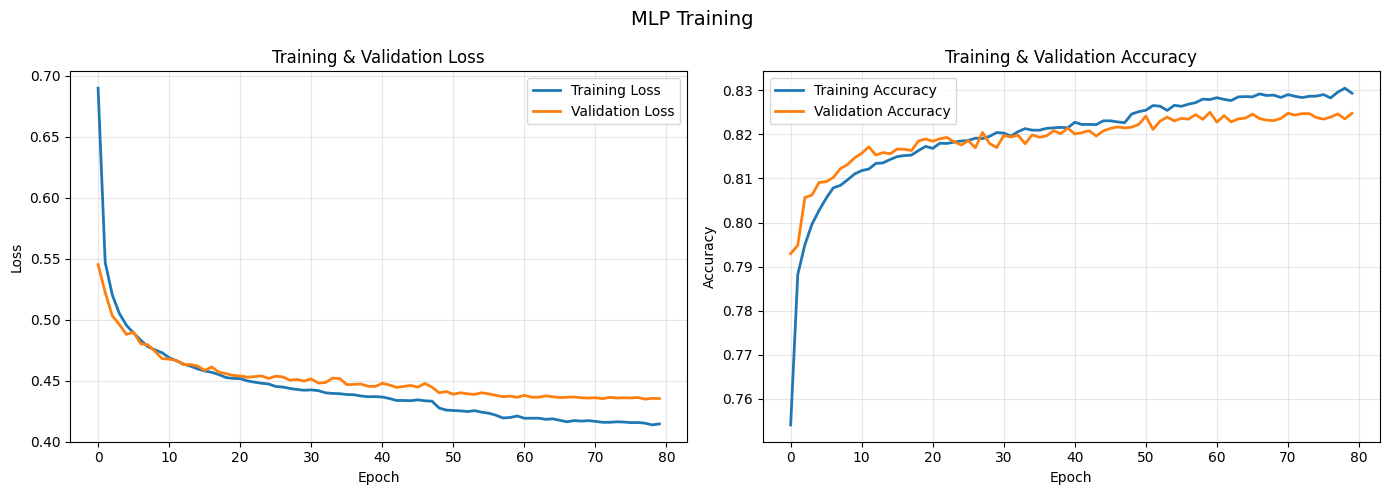

In [5]:
results['Original (41D)']=train_mlp_classifier(X_org_combined, X_org_test, y_org_combined, y_org_test)

Input features: 18
Number of classes: 10
Hidden layers: [256, 128, 64]


c:\Users\user\Faks\neuronske_mreze\projekat\venv\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Total parameters: 48,458

Pocinje treniranje...
Epoch 1/80
697/697 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.6944 - loss: 0.8215 - val_accuracy: 0.7760 - val_loss: 0.5829 - learning_rate: 5.0000e-04
Epoch 2/80
697/697 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7350 - loss: 0.6704 - val_accuracy: 0.7902 - val_loss: 0.5451 - learning_rate: 5.0000e-04
Epoch 3/80
697/697 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7441 - loss: 0.6365 - val_accuracy: 0.7911 - val_loss: 0.5321 - learning_rate: 5.0000e-04
Epoch 4/80
697/697 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7476 - loss: 0.6182 - val_accuracy: 0.7858 - val_loss: 0.5198 - learning_rate: 5.0000e-04
Epoch 5/80
697/697 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7534 - loss: 0.6038 - val_accuracy: 0.7857 - val_loss: 0.5137 - learning_rate: 5.0000e-04
Epoch 6/80
697/697 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7551 - loss: 0.5939 - val_accuracy: 0.8002 - val_loss: 0.5026 - learning_rate: 5.0000e-04
Epoch 7/

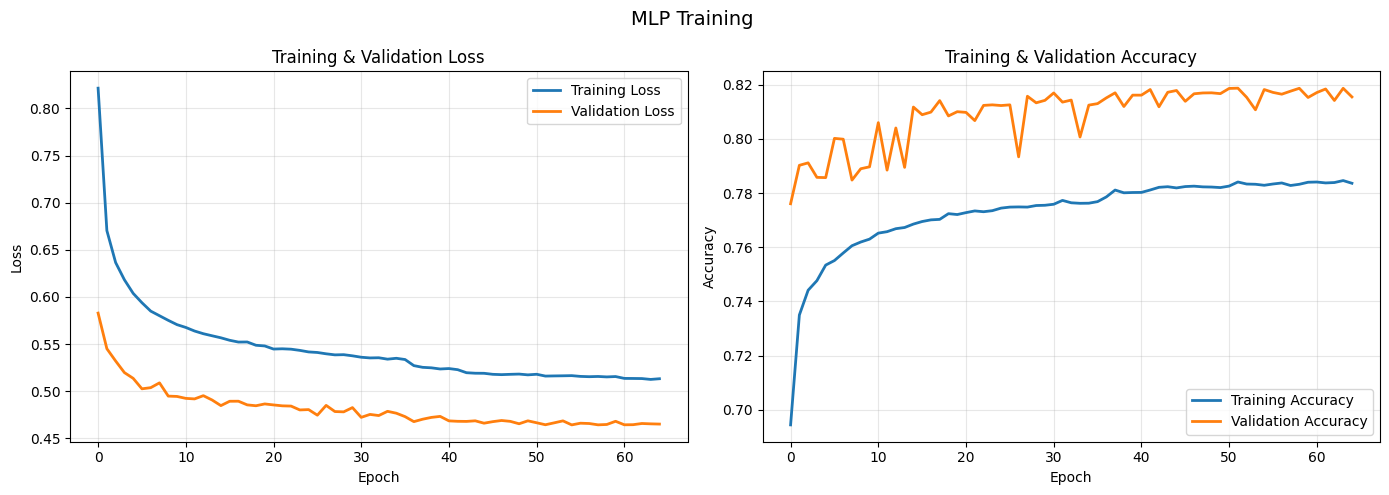

In [6]:
results['DT/Corr feature selection (18D)']=train_mlp_classifier(X_combined, X_test, y_combined, y_test)

Input features: 16
Number of classes: 10
Hidden layers: [256, 128, 64]


c:\Users\user\Faks\neuronske_mreze\projekat\venv\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Total parameters: 47,946

Pocinje treniranje...
Epoch 1/80
617/617 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.7493 - loss: 0.6955 - val_accuracy: 0.7817 - val_loss: 0.5653 - learning_rate: 5.0000e-04
Epoch 2/80
617/617 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7828 - loss: 0.5633 - val_accuracy: 0.7895 - val_loss: 0.5388 - learning_rate: 5.0000e-04
Epoch 3/80
617/617 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7908 - loss: 0.5367 - val_accuracy: 0.7973 - val_loss: 0.5198 - learning_rate: 5.0000e-04
Epoch 4/80
617/617 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7940 - loss: 0.5219 - val_accuracy: 0.8008 - val_loss: 0.5106 - learning_rate: 5.0000e-04
Epoch 5/80
617/617 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7971 - loss: 0.5132 - val_accuracy: 0.8020 - val_loss: 0.5026 - learning_rate: 5.0000e-04
Epoch 6/80
617/617 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8000 - loss: 0.5055 - val_accuracy: 0.8045 - val_loss: 0.5000 - learning_rate: 5.0000e-04
Epoch 7/

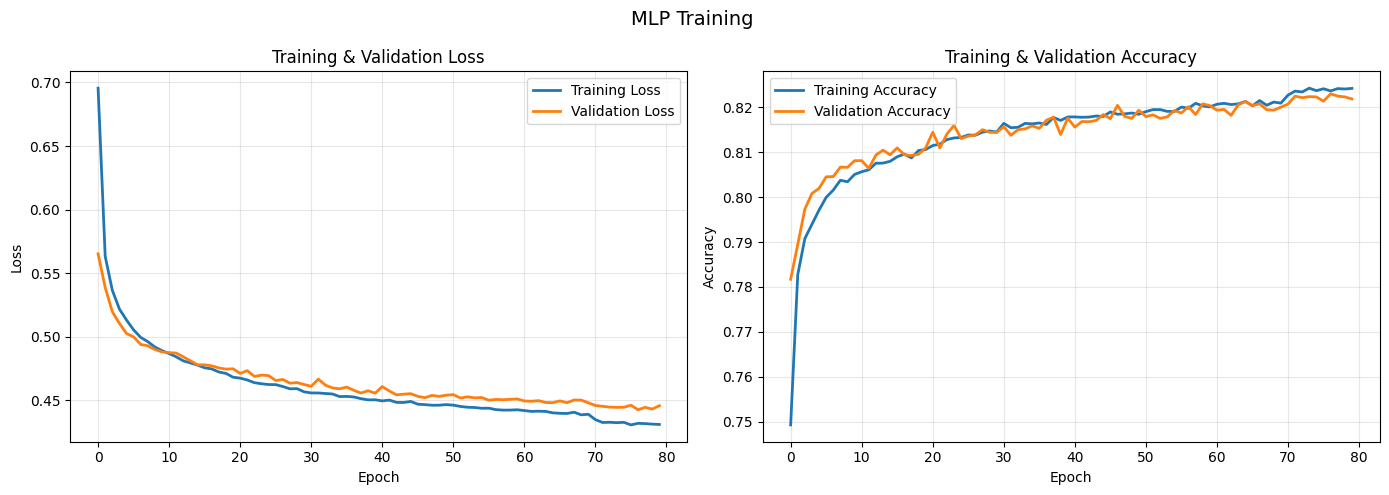

In [7]:
results['PCA (16D)'] = train_mlp_classifier(X_pca_combined, X_test_pca, y_pca_combined, y_test)

Input features: 20
Number of classes: 10
Hidden layers: [256, 128, 64]


c:\Users\user\Faks\neuronske_mreze\projekat\venv\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Total parameters: 48,970

Pocinje treniranje...
Epoch 1/80
617/617 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.7457 - loss: 0.7118 - val_accuracy: 0.7802 - val_loss: 0.5815 - learning_rate: 5.0000e-04
Epoch 2/80
617/617 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7806 - loss: 0.5725 - val_accuracy: 0.7898 - val_loss: 0.5472 - learning_rate: 5.0000e-04
Epoch 3/80
617/617 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7879 - loss: 0.5484 - val_accuracy: 0.7951 - val_loss: 0.5339 - learning_rate: 5.0000e-04
Epoch 4/80
617/617 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7911 - loss: 0.5340 - val_accuracy: 0.7949 - val_loss: 0.5246 - learning_rate: 5.0000e-04
Epoch 5/80
617/617 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7947 - loss: 0.5238 - val_accuracy: 0.7949 - val_loss: 0.5208 - learning_rate: 5.0000e-04
Epoch 6/80
617/617 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7960 - loss: 0.5179 - val_accuracy: 0.7991 - val_loss: 0.5159 - learning_rate: 5.0000e-04
Epoch 7/

c:\Users\user\Faks\neuronske_mreze\projekat\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\Faks\neuronske_mreze\projekat\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\Faks\neuronske_mreze\projekat\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

                precision    recall  f1-score   support

      Analysis       0.00      0.00      0.00       677
      Backdoor       0.35      0.04      0.07       583
           DoS       0.60      0.07      0.13      4089
      Exploits       0.56      0.93      0.70     11128
       Fuzzers       0.27      0.60      0.37      6062
       Generic       1.00      0.88      0.93     18871
        Normal       0.95      0.75      0.84     37000
Reconnaissance       0.85      0.78      0.82      3496
     Shellcode       0.38      0.51      0.44       378
         Worms       0.00      0.00      0.00        44

      accuracy                           0.75     82328
     macro avg       0.50      0.46      0.43     82328
  weighted avg       0.82      0.75      0.76     82328



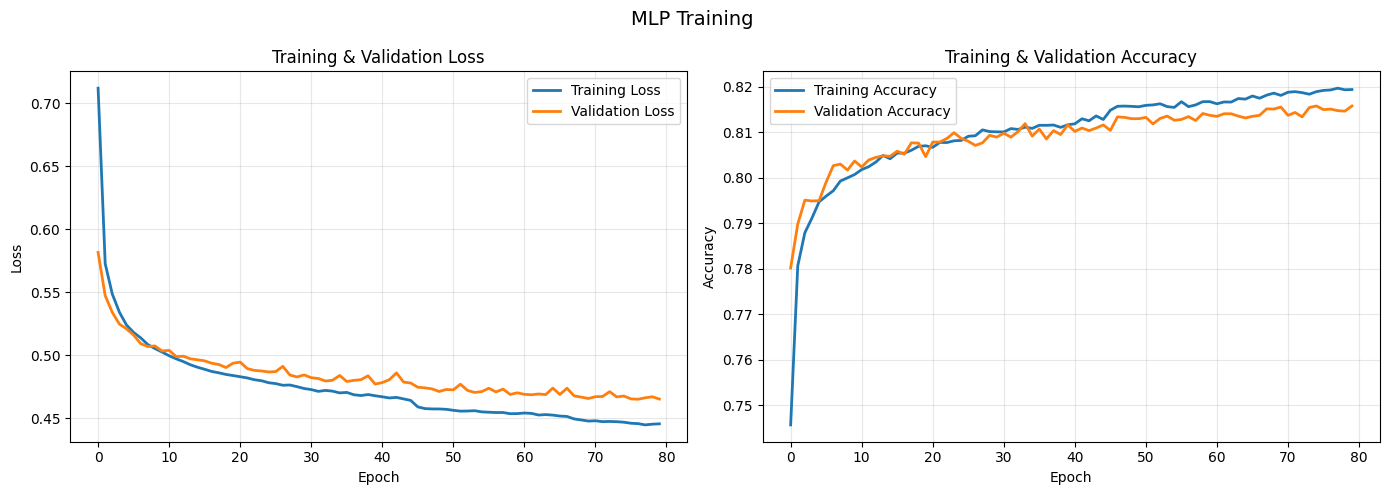

In [8]:
results['Autoenkoder (20D)'] = train_mlp_classifier(X_train_autoenc, X_test_autoenc, y_train_autoenc, y_test_eutoenc)

In [9]:
joblib.dump(results, 'mlp_results.pkl')

['mlp_results.pkl']


 Poredjenje performansi razlicitih modela:

                                 Accuracy  F1 Macro  F1 Weighted  \
PCA (16D)                          0.7639    0.4667       0.7708   
Original (41D)                     0.7442    0.4505       0.7530   
DT/Corr feature selection (18D)    0.7260    0.4492       0.7456   
Autoenkoder (20D)                  0.7491    0.4295       0.7573   

                                 Train Time (s)  
PCA (16D)                              659.7873  
Original (41D)                         677.1403  
DT/Corr feature selection (18D)        591.3148  
Autoenkoder (20D)                      648.4712  


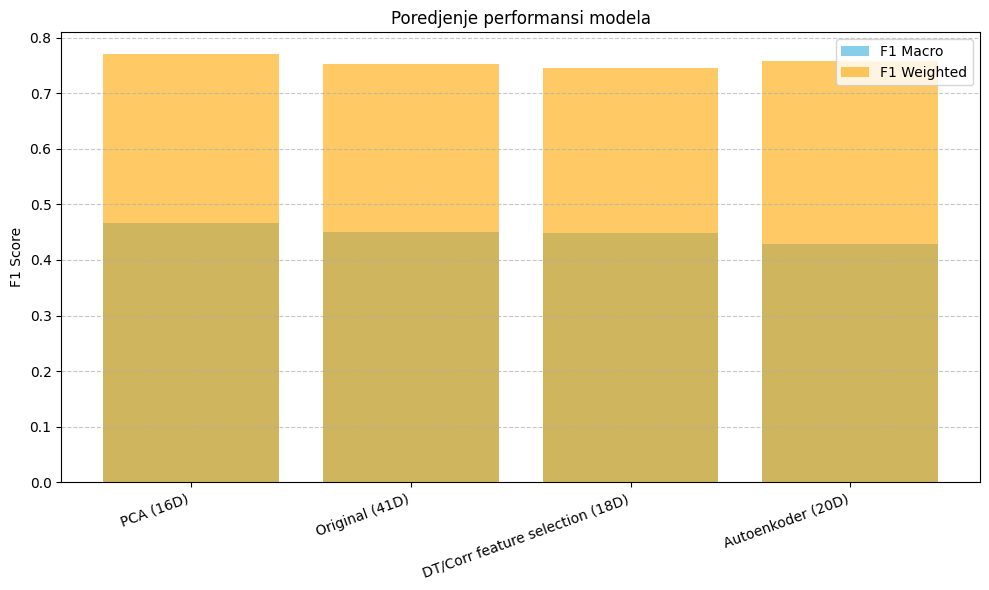

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

comparison_df = pd.DataFrame({
    model_name: {
        'Accuracy': res['accuracy'],
        'F1 Macro': res['f1_macro'],
        'F1 Weighted': res['f1_weighted'],
        'Train Time (s)': res['train_time']
    }
    for model_name, res in results.items()
}).T

comparison_df = comparison_df.sort_values(by='F1 Macro', ascending=False)

print("\n Poredjenje performansi razlicitih modela:\n")
print(comparison_df.round(4))

plt.figure(figsize=(10,6))
plt.bar(comparison_df.index, comparison_df['F1 Macro'], color='skyblue', label='F1 Macro')
plt.bar(comparison_df.index, comparison_df['F1 Weighted'], color='orange', alpha=0.6, label='F1 Weighted')
plt.ylabel('F1 Score')
plt.title('Poredjenje performansi modela')
plt.xticks(rotation=20, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
